## Convex Optimization in AI

### Overview:

Notes explaining convex functions, convex optimization problems, and why they matter.

Introduction to duality and why it helps.

Implementation of a linear SVM via its dual formulation using cvxpy.

Plotting of decision boundary, margins, and support vectors.

Comparison with scikit-learn's SVC.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import cvxpy as cp

np.random.seed(0)

## What is a convex optimization problem?

A convex optimization problem has the form:

min𝑥 𝑓(𝑥), subjected to 𝑔𝑖(𝑥) ≤ 0, ℎ𝑗(𝑥) = 0

The function 
𝑓(𝑥) is convex and each inequality constraint 𝑔𝑖(𝑥) is convex. Equality constraints are typically affine or linear.

A set is convex if for any two points in the set, the line segment between them is also in the set.

### What makes a function convex?

For twice-differentiable functions, convexity is equivalent to the Hessian being positive semidefinite everywhere.

Intuitively, convex functions have a single basin; no local minima apart from the global minimum.

### Why are convex problems important?

Any local optimum is a global optimum.

There are mature, reliable algorithms like QP solvers with strong guarantees.

## Duality

### Duality idea:

Many constrained problems can be transformed into a dual problem. The dual often has fewer variables and can be easier to solve.

### Why duality helps in SVMs:

The SVM dual formulation expresses the solution in terms of dot products between training points. This leads directly to kernels and efficient solvers for high-dimensional implicit feature spaces.

## Linear SVM (Primal & Dual)

### Primal SVM:

min 𝑤,𝑏,𝜉  1/2 ∥𝑤∥^2 + 𝐶∑𝑖𝜉𝑖, subjected to 𝑦𝑖(𝑤𝑇𝑥𝑖 + 𝑏) ≥ 1 − 𝜉𝑖,  𝜉𝑖 ≥ 0.

### Dual SVM:

Let 𝛼𝑖 be dual variables. Then,
max𝛼 ∑𝑖𝛼𝑖 − 1/2 ∑𝑖,𝑗 𝛼𝑖𝛼𝑗𝑦𝑖𝑦𝑗𝑥𝑖𝑇𝑥𝑗, subjected to 0 ≤ 𝛼𝑖 ≤𝐶 and ∑𝑖 𝛼𝑖𝑦𝑖 = 0.

We typically solve the minimization form used by QP solvers:
min𝛼 1/2 𝛼𝑇𝑄𝛼 − 1𝑇𝛼 subjected to 0 ≤ 𝛼 ≤ 𝐶,  𝑦𝑇𝛼=0, 
where 𝑄𝑖𝑗 = 𝑦𝑖𝑦𝑗𝑥𝑖𝑇𝑥𝑗.


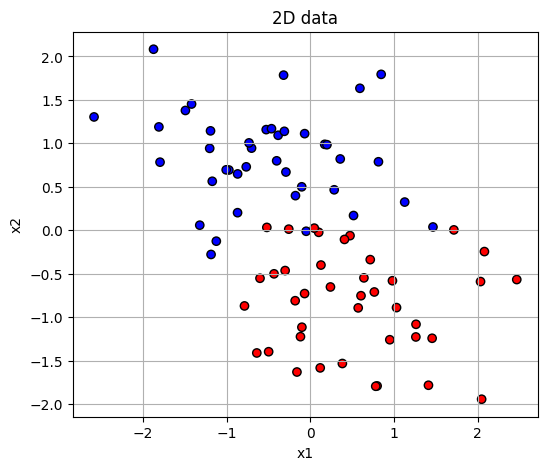

In [ ]:
# Generate a simple 2D, linearly separable dataset
X, y = datasets.make_blobs(n_samples=80, centers=2, n_features=2, cluster_std=1.0)
# Make labels in {-1, +1}
y = 2*(y) - 1


# standardize features used in normalizing that used for numerical stability
X_scaled = StandardScaler().fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap='bwr', edgecolors='k')
plt.title('2D data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)
plt.show()

In [ ]:
# Build Q = (y y^T) * (X X^T)
n = X_scaled.shape[0]
Y = y.reshape(-1,1)
K = X_scaled @ X_scaled.T # linear kernel matrix or gram matrix measures similarity between samples x_i and x_j.
Q = (Y @ Y.T) * K # determines how each pair of training points influences the shape and position of the separating hyperplane.

# cvxpy requires a symmetric PSD matrix for quadratic form;
Q = 0.5*(Q + Q.T)


# Vector of ones used in the linear term.
ones = np.ones(n)

# Regularization parameter
C = 1.0


print('Shape Q:', Q.shape)

Shape Q: (80, 80)


In [ ]:
# Define variable
alpha = cp.Variable(n)

Q = cp.psd_wrap(Q)

# Objective: (1/2) alpha^T Q alpha - 1^T alpha
objective = cp.Minimize(0.5 * cp.quad_form(alpha, Q) - ones.T @ alpha)


# Constraints: 0 <= alpha <= C, y^T alpha == 0
constraints = [alpha >= 0, alpha <= C, y @ alpha == 0]


prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.OSQP, verbose=False) # Operator Splitting Quadratic Program solver.


print('Status:', prob.status)
print('Optimal value:', prob.value) # gives the minimized value of the dual objective


alpha_opt = alpha.value
print('Some alpha values:', alpha_opt[:10])

Status: optimal
Optimal value (dual objective): -15.05072972127072
Some alpha values (first 10): [ 1.00000000e+00 -4.25977557e-20 -5.00953861e-20 -9.27348200e-20
 -3.44903240e-20 -2.43531229e-20 -3.44413143e-21 -1.93223025e-20
 -2.08385454e-20 -3.49701758e-20]


In [ ]:
# Compute w = sum_i alpha_i y_i x_i
w = (alpha_opt * y) @ X_scaled


# Support vectors: those with alpha > eps (and typically < C for margin SVs)
eps = 1e-5
sv_mask = alpha_opt > eps
sv_indices = np.where(sv_mask)[0]


# Compute bias b by averaging over support vectors with 0 < alpha < C
margin_sv_mask = (alpha_opt > eps) & (alpha_opt < C - 1e-8)
if margin_sv_mask.sum() > 0:
    b_vals = []
    for i in np.where(margin_sv_mask)[0]:
        b_vals.append(y[i] - X_scaled[i].dot(w))
    b = np.mean(b_vals)
else:
    # fallback; average over all support vectors
    b = np.mean([y[i] - X_scaled[i].dot(w) for i in sv_indices])


print('w:', w)
print('b:', b)
print('Number of support vectors:', sv_mask.sum())

w: [ 0.56666178 -2.36165937]
b: 0.0369651671498234
Number of support vectors: 19


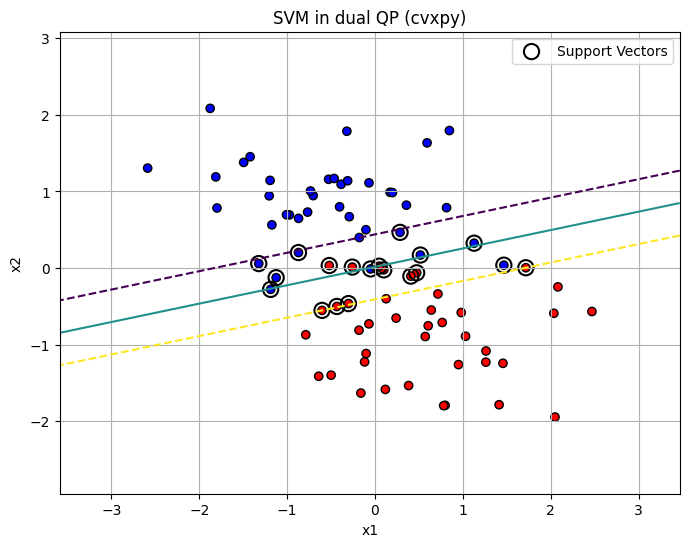

In [13]:
# plot
xx = np.linspace(X_scaled[:,0].min()-1, X_scaled[:,0].max()+1, 500)
yy = np.linspace(X_scaled[:,1].min()-1, X_scaled[:,1].max()+1, 500)
XX, YY = np.meshgrid(xx, yy)
grid = np.c_[XX.ravel(), YY.ravel()]
Z = grid.dot(w) + b
Z = Z.reshape(XX.shape)


plt.figure(figsize=(8,6))
# plot decision boundary and margins
plt.contour(XX, YY, Z, levels=[-1.0, 0.0, 1.0], linestyles=['--','-','--'])


# plot points
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap='bwr', edgecolors='k')
plt.scatter(X_scaled[sv_indices,0], X_scaled[sv_indices,1], s=120, facecolors='none', edgecolors='k', linewidths=1.5, label='Support Vectors')


plt.title('SVM in dual QP (cvxpy)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()

sklearn w: [ 0.56666184 -2.36165936]
sklearn b: 0.03696523852092982
sklearn #SV: 19


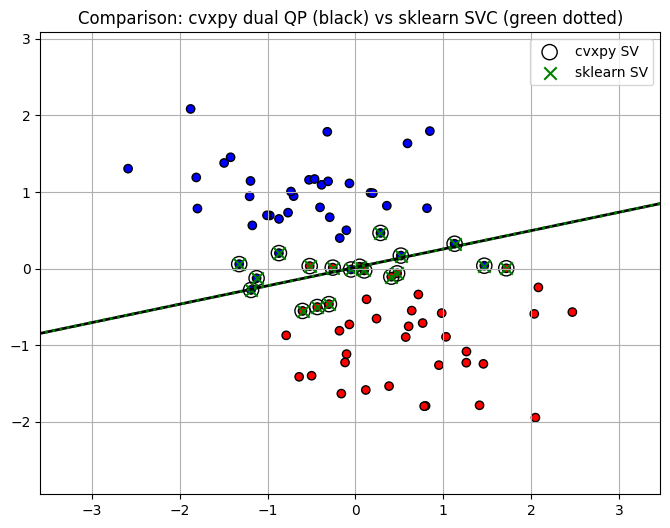

cvxpy SVM training accuracy: 0.9375
sklearn SVC training accuracy: 0.9375


In [14]:
svc = SVC(kernel='linear', C=C)
svc.fit(X_scaled, y)


# sklearn parameters
w_skl = svc.coef_.flatten()
b_skl = svc.intercept_[0]
sv_idx_skl = svc.support_


print('sklearn w:', w_skl)
print('sklearn b:', b_skl)
print('sklearn #SV:', len(sv_idx_skl))


# Plot both solutions for comparison
plt.figure(figsize=(8,6))
# cvxpy decision boundary
Z_cvx = grid.dot(w) + b
Z_cvx = Z_cvx.reshape(XX.shape)
plt.contour(XX, YY, Z_cvx, levels=[0.0], colors='k', linewidths=2, linestyles='-')
# sklearn decision boundary
Z_skl = grid.dot(w_skl) + b_skl
Z_skl = Z_skl.reshape(XX.shape)
plt.contour(XX, YY, Z_skl, levels=[0.0], colors='g', linewidths=2, linestyles=':')

plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap='bwr', edgecolors='k')
plt.scatter(X_scaled[sv_indices,0], X_scaled[sv_indices,1], s=120, facecolors='none', edgecolors='k', label='cvxpy SV')
plt.scatter(X_scaled[sv_idx_skl,0], X_scaled[sv_idx_skl,1], s=80, marker='x', c='green', label='sklearn SV')
plt.title('Comparison: cvxpy dual QP (black) vs sklearn SVC (green dotted)')
plt.legend()
plt.grid(True)
plt.show()


# numeric comparison
from sklearn.metrics import accuracy_score
pred_cvx = np.sign(X_scaled.dot(w) + b)
pred_skl = svc.predict(X_scaled)
print('cvxpy SVM training accuracy:', accuracy_score(y, pred_cvx))
print('sklearn SVC training accuracy:', accuracy_score(y, pred_skl))

## Interpretation

The SVM primal and dual are convex problems; solving either gives a globally optimal classifier.

The dual formulation is especially powerful because it depends on inner products between training points; enabling kernels for non-linear decision boundaries.

Comparing the custom dual solution with scikit-learn shows nearly identical decision boundaries and support vectors.